# GJ9827-b

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt

In [3]:
name = 'GJ9827b'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/other/15428_visit2/*.fits'))
fnames = np.hstack([fnames, glob(f'/Volumes/Nibelheim/hst/data/other/15428_visit1_B/*.fits')])
fnames = np.sort(fnames)
obs = om.Observation.from_files(fnames, planet_letter='b')

/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

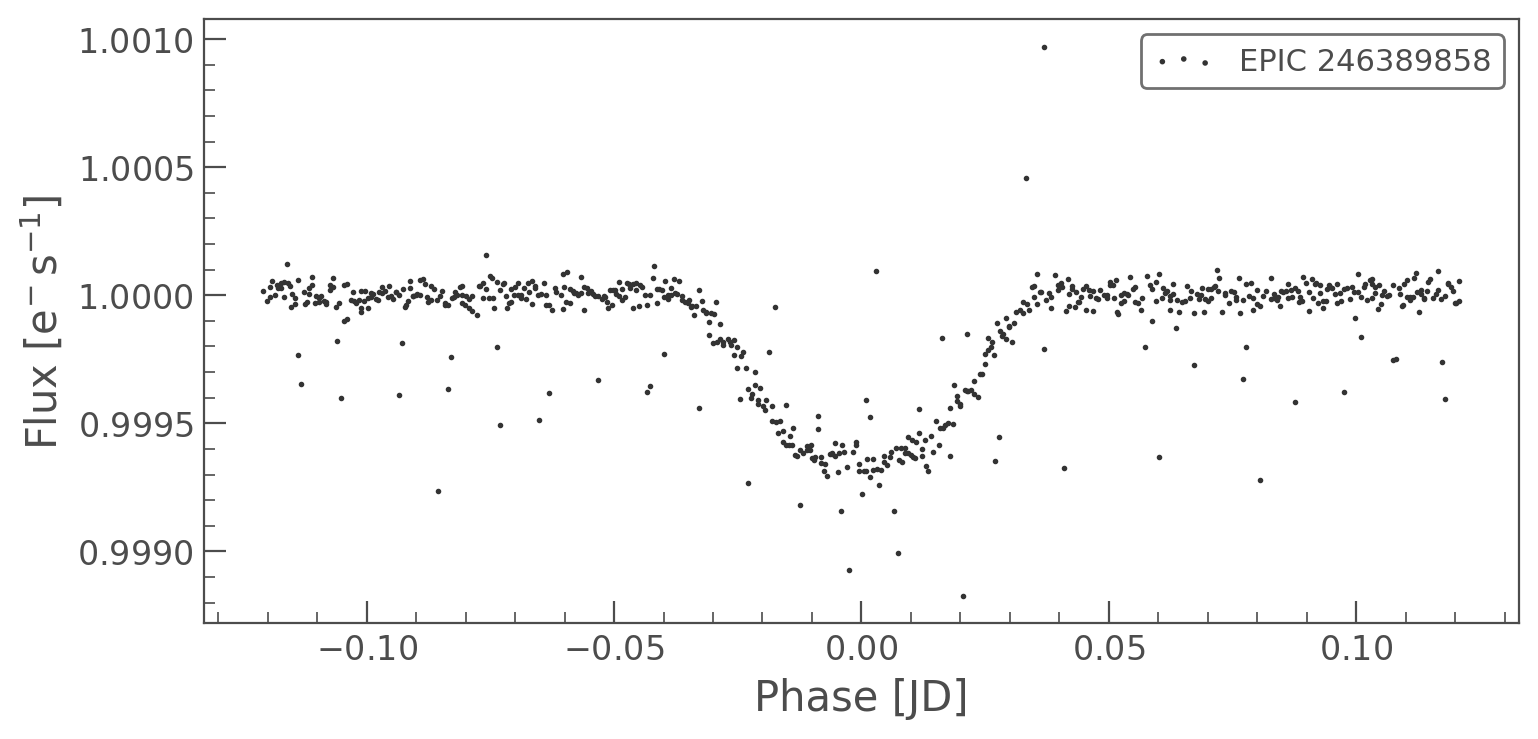

In [5]:
import lightkurve as lk
import astropy.units as u
clc = lk.search_lightcurve('GJ9827', mission='K2', author='k2sff').download().flatten(51)
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s
k = np.abs(((clc.time.value - (obs.t0 - 2454833 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2454833).scatter()

In [6]:
ps = [3.6480957, 6.2014698] 
t0s = [2457742.19930 - 2454833, 2457740.96115 - 2454833]
durs = [1.825/24, 1.223/24]
tmask = np.asarray([~clc.to_periodogram('bls', period=[p, p], duration=dur).get_transit_mask(period=p, duration=dur, transit_time=t0) for p, t0, dur in zip(ps, t0s, durs)]).all(axis=0)
k &= tmask

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

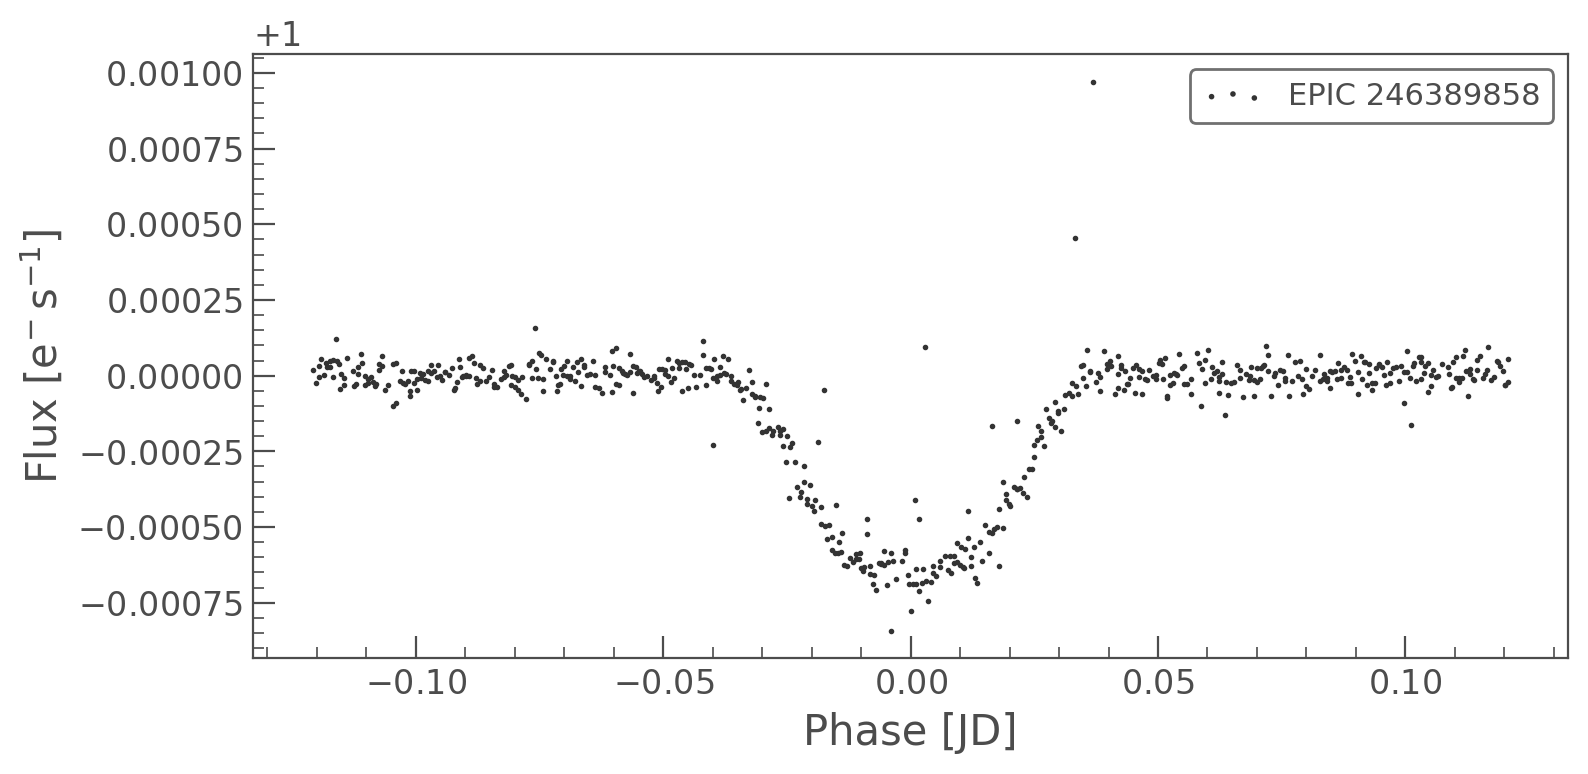

In [7]:
clc[k].fold(obs.period, obs.t0 - 2454833).scatter()

In [8]:
obs

GJ-9827 [2 Visits]

In [9]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2454833,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

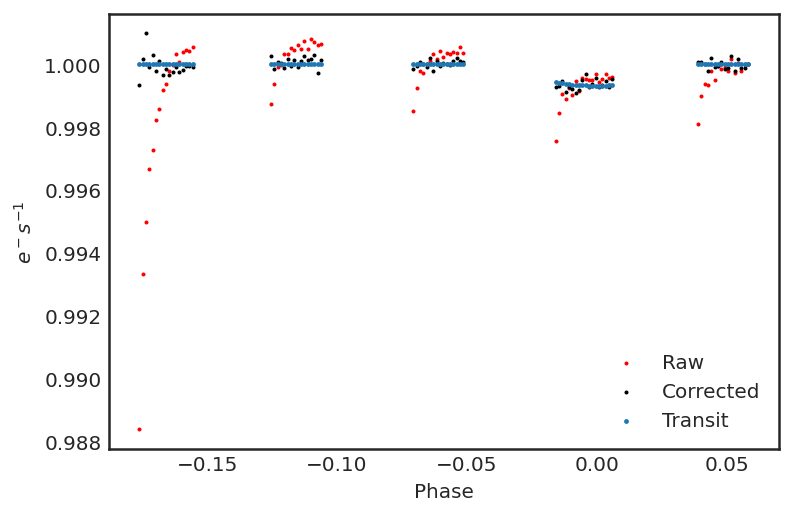

In [10]:
obs.plot()

In [11]:
obs.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/2 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model:  50%|█████     | 1/2 [00:27<00:27, 27.67s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 2/2 [00:54<00:00, 26.97s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 2/2 [00:54<00:00, 27.08s/it]

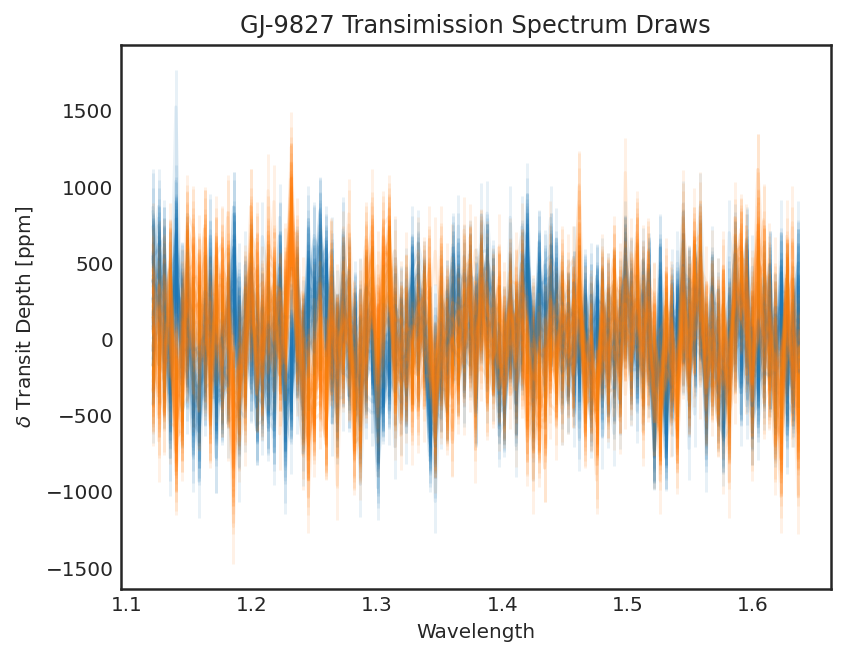

In [12]:
obs.plot_spectra()

<AxesSubplot:title={'center':'GJ-9827 Transmission Spectrum, Visit: 1'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

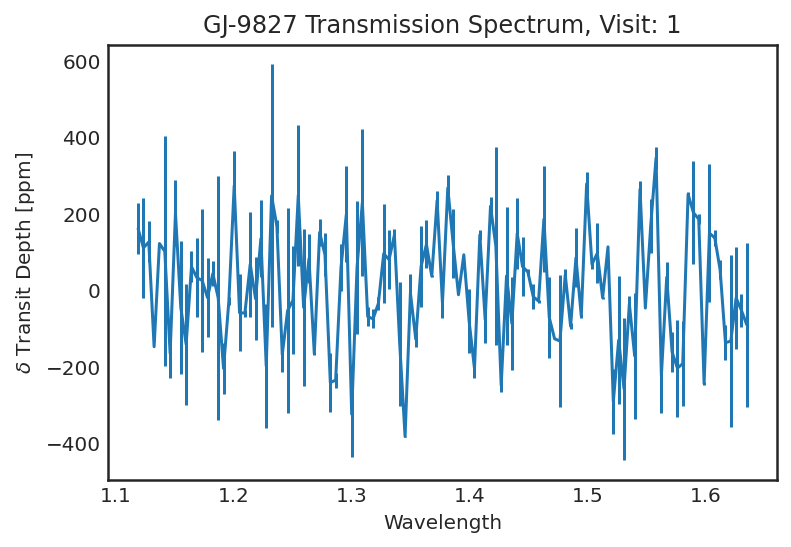

In [13]:
om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

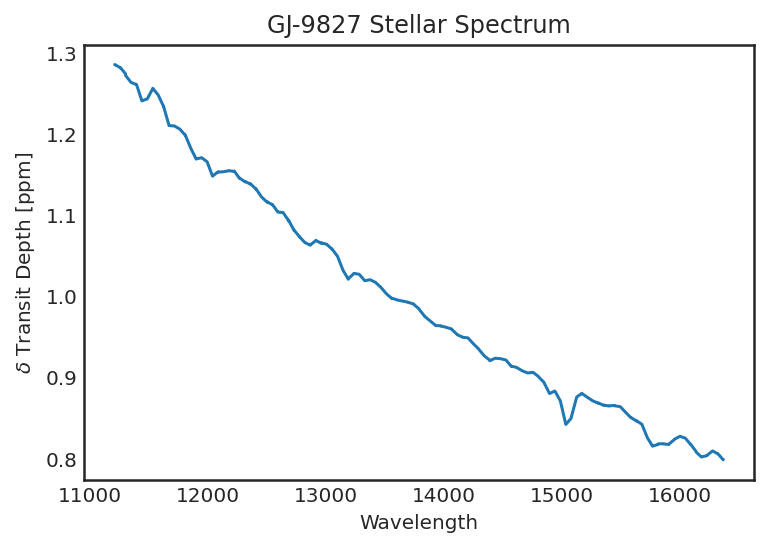

In [14]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [15]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

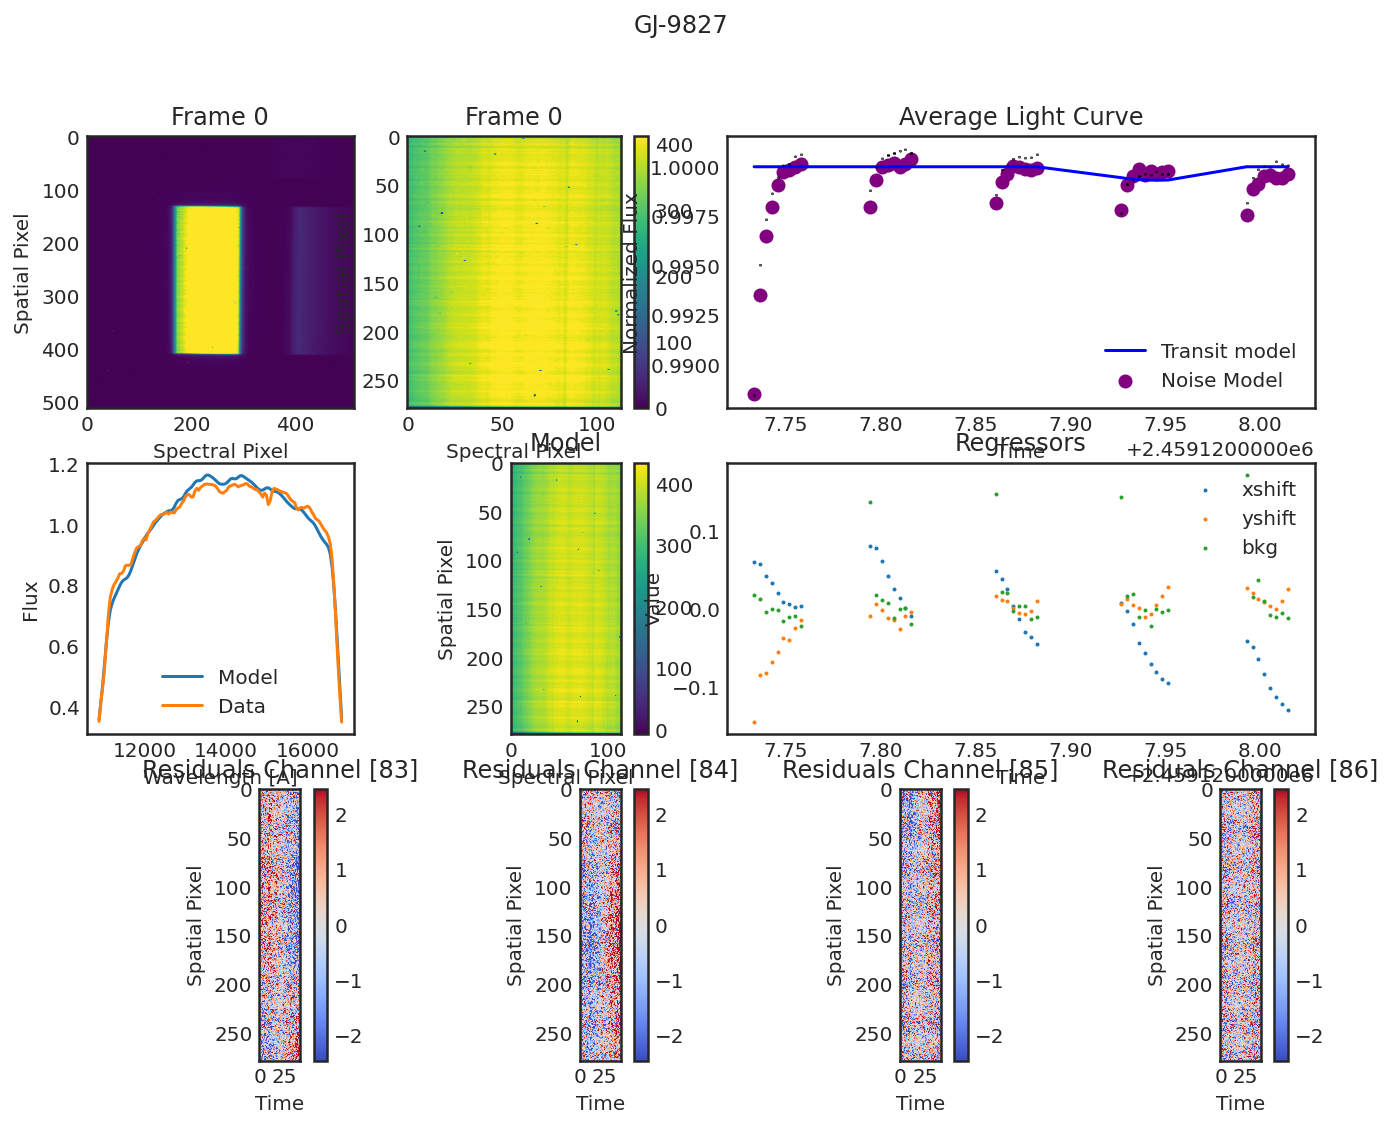

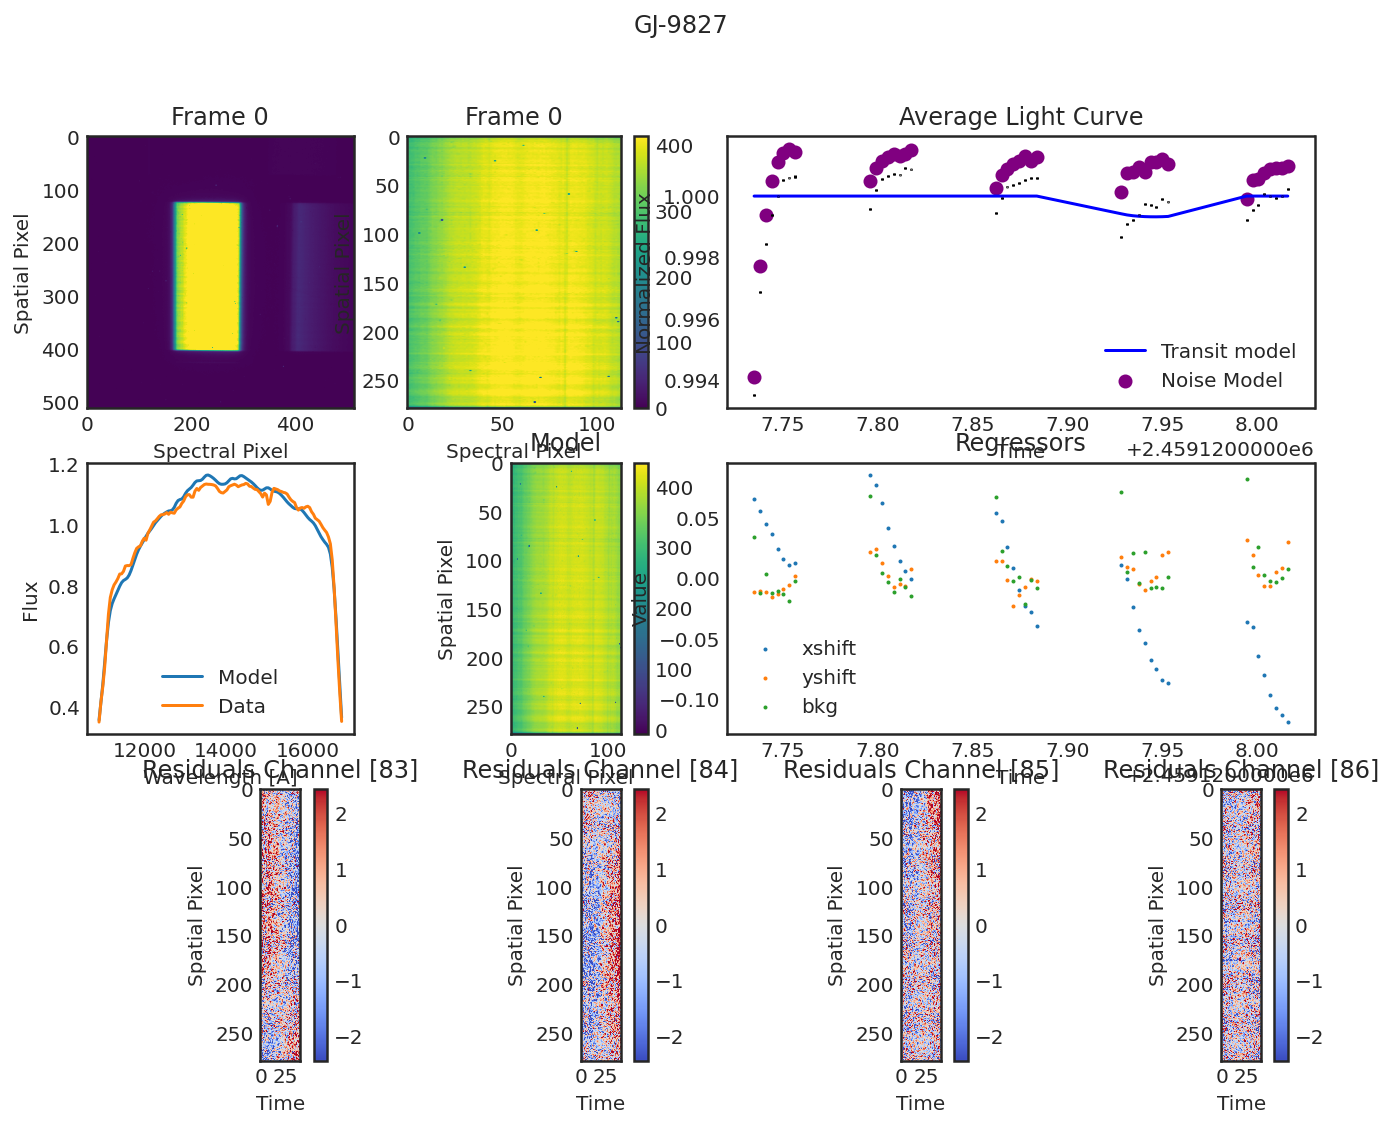

In [16]:
for visit in obs:
    visit.diagnose();
    plt.show();